In [1]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from os import listdir
from os.path import isfile, join, basename
from matplotlib import pyplot as plt

In [2]:
# Custom Dataset for Speech Data
class SpeechDataset(Dataset):
    def __init__(self, directory_path, transform=None):
        self.file_paths = [directory_path + f for f in listdir(directory_path)]
        self.labels = [int(basename(path)[0]) for path in self.file_paths]
        self.transform = transform
        x = list(filter(lambda x: x[1] in [0, 1], zip(self.file_paths, self.labels)))
        self.file_paths = list(map(lambda x: x[0], x))
        self.labels = list(map(lambda x: x[1], x))
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.file_paths[idx], format='wav')
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, self.labels[idx]

# LSTM Model for Speech Recognition
class SpeechRecognitionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SpeechRecognitionRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM expects input as (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

In [3]:
input_size = 64
# Preprocessing Pipeline
transform = T.MelSpectrogram(sample_rate=8000, n_mels=input_size, win_length=255, hop_length=128)

In [ ]:
# Hyperparameters

hidden_size = 128
output_size = 2  
num_layers = 2
learning_rate = 0.001
batch_size = 1
num_epochs = 10

# Example Data (Replace with actual paths and labels)
directory_path = "./datasets/audio-mnist/01/"
# Replace with actual labels (e.g., indices for characters/words)

# Dataset and DataLoader
dataset = SpeechDataset(directory_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

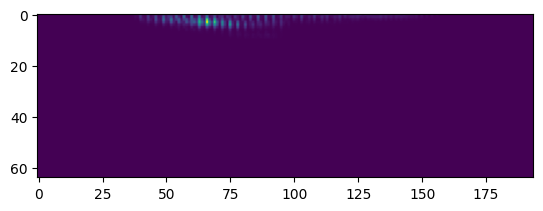

In [5]:
for waveforms, labels in dataloader:
    plt.imshow(waveforms[0][0])
    plt.show()
    break

In [6]:
# Model, Loss, and Optimizer
model = SpeechRecognitionRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Replace with CTC loss for sequence alignment tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    for waveforms, labels in dataloader:
        waveforms = waveforms.squeeze(1)  # Adjust dimensions as needed
        waveforms = waveforms.transpose(1, 2)  # Shape: (batch_size, seq_len, input_size)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.9480
Epoch 2/10, Loss: 0.7068
Epoch 3/10, Loss: 0.6373
Epoch 4/10, Loss: 0.7441
Epoch 5/10, Loss: 0.4442
Epoch 6/10, Loss: 0.4190
Epoch 7/10, Loss: 0.5133


KeyboardInterrupt: 